# Logistic regression early stopping vs ridge regularizationregularization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import dotenv
import pandas as pd
import mlflow
import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.subplots
import plotly.io as pio
import matplotlib.patches

import typing
import os
import shutil
import sys

In [2]:
EXPORT = False
SHOW_TITLES = not EXPORT
REGULARIZED_EXPERIMENT_NAME = 'logistic_regression_early_stopping_regularized'
GD_EXPERIMENT_NAME = 'logistic_regression_early_stopping_gd'
EXPORT_NAME = 'logistic_regression_early_stopping'

In [3]:
# Load environment variables
dotenv.load_dotenv()

# Enable loading of the project module
MODULE_DIR = os.path.join(os.path.abspath(os.path.join(os.path.curdir, os.path.pardir, os.pardir)), 'src')
sys.path.append(MODULE_DIR)

In [4]:
%load_ext autoreload
%autoreload 2
import interpolation_robustness as ir

In [5]:
FIGURE_SIZE = (2.6, 1.8)
LEGEND_FONT_SIZE = ir.plots.FONT_SIZE_SMALL_PT
LEGEND_FIGURE_SIZE = (5.5, 0.55)

ir.plots.setup_matplotlib(show_titles=SHOW_TITLES)

In [6]:
if EXPORT:
    EXPORT_DIR = os.path.join(ir.util.REPO_ROOT_DIR, 'logs', f'export_{EXPORT_NAME}')
    print('Using export directory', EXPORT_DIR)
    if os.path.exists(EXPORT_DIR):
        shutil.rmtree(EXPORT_DIR)
    os.makedirs(EXPORT_DIR)

def export_fig(fig: plt.Figure, filename: str):
    # If export is disabled then do nothing
    if EXPORT:
        export_path = os.path.join(EXPORT_DIR, filename)
        fig.savefig(export_path)
        print('Exported figure at', export_path)


## Load experiment data

In [7]:
def load_runs(experiment_name: str) -> pd.DataFrame:
    client = mlflow.tracking.MlflowClient()
    experiment = client.get_experiment_by_name(experiment_name)
    all_runs = mlflow.search_runs(
        experiment.experiment_id
    )
    all_runs = all_runs.set_index('run_id', drop=False)  # set index, but keep column to not break stuff depending on it

    # Convert some parameters to numbers and sort accordingly
    all_runs['params.data_dim'] = all_runs['params.data_dim'].astype(int)
    all_runs['params.train_attack_epsilon'] = all_runs['params.train_attack_epsilon'].astype(np.float)
    all_runs['params.test_attack_epsilon'] = all_runs['params.test_attack_epsilon'].astype(np.float)
    all_runs['params.l2_lambda'] = all_runs['params.l2_lambda'].astype(np.float)
    all_runs = all_runs.sort_values(['params.l2_lambda'], ascending=False)
    print('Loaded', len(all_runs), 'runs of experiment', experiment_name)
    assert all_runs['status'].eq('FINISHED').all()
    assert all_runs['params.train_consistent_attacks'].eq('True').all()
    return all_runs

regularized_runs = load_runs(REGULARIZED_EXPERIMENT_NAME)
gd_runs = load_runs(GD_EXPERIMENT_NAME)
assert len(gd_runs) == 1

target_metrics = ('true_std_risk', 'true_robust_risk', 'training_loss', 'output_lq_l2_norm_ratio', 'robust_margin_normalized')
gd_metrics = ir.mlflow.load_metrics(gd_runs, target_metrics, mlflow.tracking.MlflowClient())
print('Loaded', len(target_metrics), 'metrics of', len(gd_metrics.keys()), 'runs of experiment', GD_EXPERIMENT_NAME)

gd_metrics = gd_metrics[gd_runs.index[0]]

Loaded 58 runs of experiment logistic_regression_early_stopping_regularized
Loaded 1 runs of experiment logistic_regression_early_stopping_gd
Loaded 5 metrics of 1 runs of experiment logistic_regression_early_stopping_gd


## Plots

In [8]:
std_risk_color_idx = 0
robust_risk_color_idx = 1
loss_color_idx = 2
norm_color_idx = 5

risk_linestyle_idx = 0
loss_linestyle_idx = 2
norm_linestyle_idx = 1

data_dim, = regularized_runs['params.data_dim'].unique()
num_samples, = regularized_runs['params.data_num_train_samples'].astype(int).unique()
train_attack_epsilon, = regularized_runs['params.train_attack_epsilon'].unique()

assert gd_runs['params.data_dim'][0] == data_dim
assert gd_runs['params.data_num_train_samples'].astype(int)[0] == num_samples
assert gd_runs['params.train_attack_epsilon'][0] == train_attack_epsilon

BASELINE_LAMBDA = 0.0

norm_y_limits = (1.0, 5.0)
risks_y_limits = (-0.001, 0.32)

### Gradient descent with early stopping

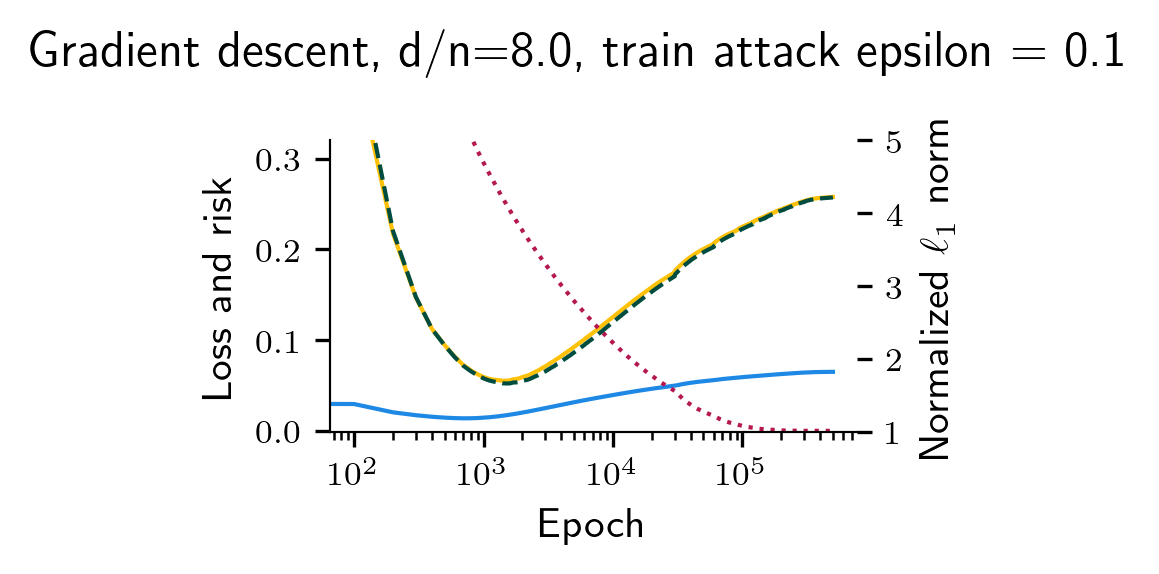

In [9]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

gd_epochs, gd_metric_values = gd_metrics

x_values = gd_epochs

ax.plot(
    x_values,
    gd_metric_values['true_std_risk'],
    label='Population standard risk',
    c=f'C{std_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[risk_linestyle_idx],
    zorder=1
)

ax.plot(
    x_values,
    gd_metric_values['true_robust_risk'],
    label='Population robust risk',
    c=f'C{robust_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[risk_linestyle_idx],
    zorder=1
)

ax.plot(
    x_values,
    gd_metric_values['training_loss'],
    label='Training loss',
    c=f'C{loss_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[loss_linestyle_idx],
    zorder=1
)

ax.set_xlabel('Epoch')
ax.set_ylim(risks_y_limits)
ax.set_xscale('log')
ax.set_ylabel('Loss and risk')

twin_label = r'Normalized $\ell_1$ norm'
twin = ax.twinx()
twin.plot(
    x_values,
    gd_metric_values['output_lq_l2_norm_ratio'],
    label=twin_label,
    c=f'C{norm_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[norm_linestyle_idx],
    zorder=1
)
twin.set_ylim(norm_y_limits)
twin.set_ylabel(twin_label)

if SHOW_TITLES:
    fig.suptitle(f'Gradient descent, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_early_stopping_gd.pdf')
plt.show()


### Ridge regularization

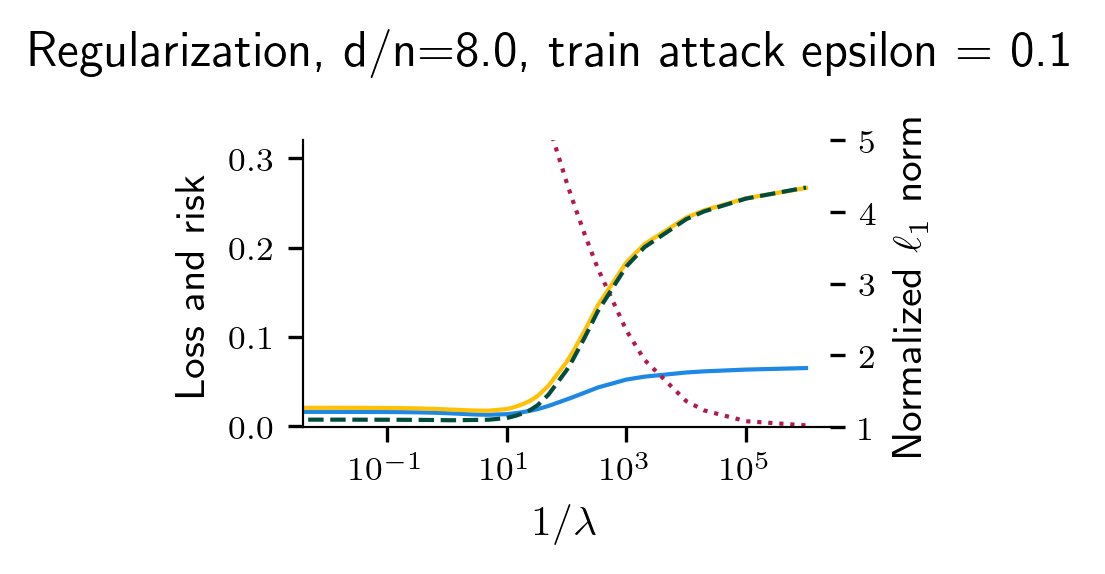

In [10]:
fig, ax = plt.subplots(figsize=FIGURE_SIZE)

x_values =  (1.0 / regularized_runs['params.l2_lambda']).round(decimals=2)
assert x_values[-1] == np.inf

# Max margin training loss is 0, but is caclulated differently, hence need to manually adjust
training_loss = regularized_runs['metrics.training_loss'].values
training_loss[-1] = 0

ax.plot(
    x_values,
    regularized_runs['metrics.true_std_risk'],
    label='Population standard risk',
    c=f'C{std_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[risk_linestyle_idx],
    zorder=1
)

ax.plot(
    x_values,
    regularized_runs['metrics.true_robust_risk'],
    label='Population robust risk',
    c=f'C{robust_risk_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[risk_linestyle_idx],
    zorder=1
)

ax.plot(
    x_values,
    training_loss,
    label='Training loss',
    c=f'C{loss_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[loss_linestyle_idx],
    zorder=1
)

ax.set_xlabel(r'$1 / \lambda$')
ax.set_ylim(risks_y_limits)
ax.set_ylabel('Loss and risk')
ax.set_xscale('log')

twin_label = r'Normalized $\ell_1$ norm'
twin = ax.twinx()
twin.plot(
    x_values,
    regularized_runs['metrics.weight_lq_l2_norm_ratio'],
    label=twin_label,
    c=f'C{norm_color_idx}',
    ls=ir.plots.LINESTYLE_MAP[norm_linestyle_idx],
    zorder=1
)
twin.set_ylim(norm_y_limits)
twin.set_ylabel(twin_label)

ax_handles, ax_labels = ax.get_legend_handles_labels()
twin_handles, twin_labels = twin.get_legend_handles_labels()

if SHOW_TITLES:
    fig.suptitle(f'Regularization, d/n={data_dim / num_samples}, train attack epsilon = {train_attack_epsilon}')

export_fig(fig, f'logreg_early_stopping_regularized.pdf')
plt.show()


In [11]:
# Legend
legend_fig = plt.figure(figsize=LEGEND_FIGURE_SIZE)

ax_handles, ax_labels = ax.get_legend_handles_labels()
twin_handles, twin_labels = twin.get_legend_handles_labels()

ir.plots.errorbar_legend(
    legend_fig,
    handles=ax_handles + twin_handles,
    labels=ax_labels + twin_labels,
    loc='center',
    ncol=2,
    frameon=True,
    fontsize=LEGEND_FONT_SIZE,
    borderpad=0.5
)

export_fig(legend_fig, f'logreg_early_stopping_legend.pdf')


<Figure size 1650x165 with 0 Axes>